In [40]:
import os
from pathlib import Path

import cv2
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

import pandas as pd
import matplotlib.pyplot as plt

# pyiqa 用于 NIQE / BRISQUE
import pyiqa
import sys
sys.path.append("../PyTorch-Image-Dehazing")

from net import dehaze_net

PROJECT_ROOT = Path("..").resolve()

OHAZE_HAZY_DIR = PROJECT_ROOT / "data" / "OHAZE" / "hazy"
RESULT_AOD_OHAZE = PROJECT_ROOT / "results" / "aod" / "ohaze"
RESULT_AOD_OHAZE.mkdir(parents=True, exist_ok=True)

METRIC_DIR = PROJECT_ROOT / "results" / "metrics"
METRIC_DIR.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [41]:
net = dehaze_net().to(device)
print(net)

dehaze_net(
  (relu): ReLU(inplace=True)
  (e_conv1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (e_conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv3): Conv2d(6, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (e_conv4): Conv2d(6, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (e_conv5): Conv2d(12, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [42]:
CKPT_PATH = "../PyTorch-Image-Dehazing/snapshots/dehazer.pth"

state = torch.load(CKPT_PATH, map_location=device)
net.load_state_dict(state)
net.eval()

print("Loaded pretrained weights.")


Loaded pretrained weights.


In [43]:
def aod_infer(image_path, net, device="cpu"):
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None:
        raise FileNotFoundError(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    inp = torch.from_numpy(img_rgb).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        out = net(inp)

    out = out.squeeze(0).permute(1, 2, 0).cpu().numpy()
    out = np.clip(out * 255.0, 0, 255).astype(np.uint8)
    return out


In [44]:
hazy_files = sorted(os.listdir(OHAZE_HAZY_DIR))
print("Number of hazy images:", len(hazy_files))
for fname in tqdm(hazy_files):
    in_path = OHAZE_HAZY_DIR / fname
    out_path = RESULT_AOD_OHAZE / fname

    result = aod_infer(in_path, net, device)
    cv2.imwrite(str(out_path), cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

print("Saved AOD-Net O-HAZE outputs to:", RESULT_AOD_OHAZE)


Number of hazy images: 4


  0%|          | 0/4 [00:00<?, ?it/s]

FileNotFoundError: /home/jil455/teams/project-team-56/Jiangrong/data/MYHAZE/.ipynb_checkpoints

In [28]:
niqe_model = pyiqa.create_metric('niqe', device=device)
brisque_model = pyiqa.create_metric('brisque', device=device)

rows = []

for fname in tqdm(hazy_files):
    hazy_path = OHAZE_HAZY_DIR / fname
    aod_path  = RESULT_AOD_OHAZE / fname

    hazy = cv2.cvtColor(cv2.imread(str(hazy_path)), cv2.COLOR_BGR2RGB)
    aod  = cv2.cvtColor(cv2.imread(str(aod_path)),  cv2.COLOR_BGR2RGB)

    # 转 tensor
    hazy_t = torch.from_numpy(hazy).permute(2,0,1).unsqueeze(0).float().to(device) / 255.
    aod_t  = torch.from_numpy(aod).permute(2,0,1).unsqueeze(0).float().to(device) / 255.

    niqe_hazy = niqe_model(hazy_t).item()
    niqe_aod  = niqe_model(aod_t).item()

    brisque_hazy = brisque_model(hazy_t).item()
    brisque_aod  = brisque_model(aod_t).item()

    rows.append([
        fname,
        niqe_hazy, niqe_aod,
        brisque_hazy, brisque_aod
    ])

columns = [
    "file",
    "niqe_hazy", "niqe_aod",
    "brisque_hazy", "brisque_aod"
]

df = pd.DataFrame(rows, columns=columns)
df.head(), df.describe()


  0%|          | 0/45 [00:00<?, ?it/s]

(                  file  niqe_hazy  niqe_aod  brisque_hazy  brisque_aod
 0  01_outdoor_hazy.jpg   4.143074  3.460742     28.077332    21.528015
 1  02_outdoor_hazy.jpg   4.108728  3.348997     22.403992    17.945007
 2  03_outdoor_hazy.JPG   4.880130  4.177926     17.157410    11.210144
 3  04_outdoor_hazy.jpg   4.614899  3.897566     22.458191    16.349792
 4  05_outdoor_hazy.jpg   5.460846  4.709773     20.293152    11.948425,
        niqe_hazy   niqe_aod  brisque_hazy  brisque_aod
 count  45.000000  45.000000     45.000000    45.000000
 mean    4.309977   3.724879     22.972253    17.858430
 std     0.612337   0.529311      3.483972     2.820530
 min     2.862597   2.856562     15.813171    11.210144
 25%     3.823891   3.283645     21.046570    16.386414
 50%     4.248881   3.623703     22.403992    17.789246
 75%     4.776824   4.111047     24.778503    19.465027
 max     5.643327   4.715859     33.508484    25.827332)

In [29]:
csv_path = METRIC_DIR / "aod_ohaze_niqe_brisque.csv"
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)


Saved: /home/jil455/teams/project-team-56/Jiangrong/results/metrics/aod_ohaze_niqe_brisque.csv


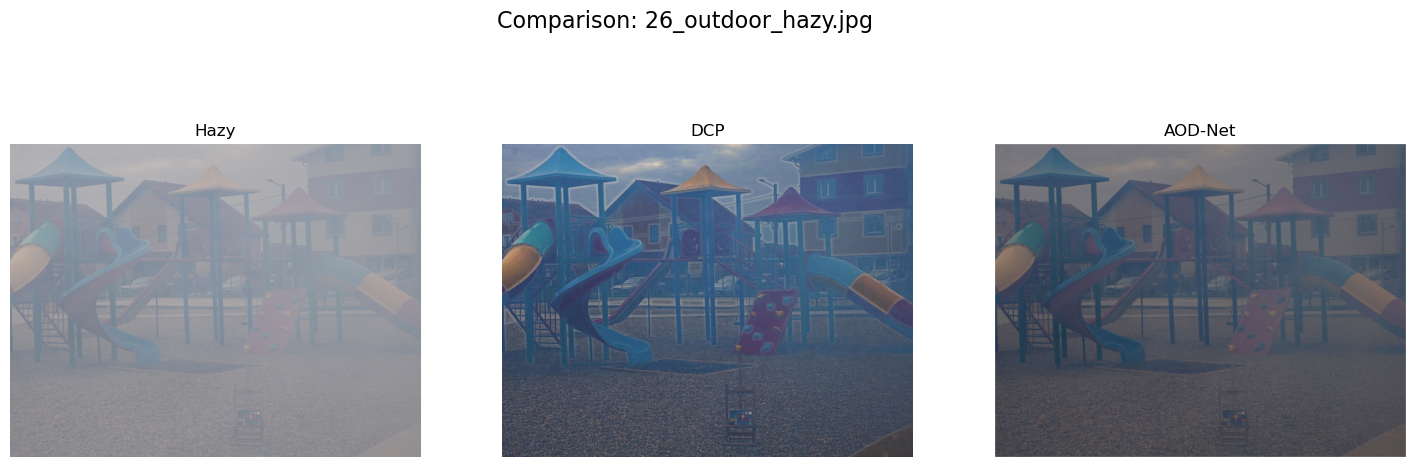

In [31]:
import matplotlib.pyplot as plt
import random

# 让你可以自己选文件，或随机选一个
def visualize_ohaze_triplet(filename=None):
    # 如果没有指定文件名，随机选择一张
    hazy_files = sorted(os.listdir(OHAZE_HAZY_DIR))
    if filename is None:
        filename = random.choice(hazy_files)
    
    hazy_path = OHAZE_HAZY_DIR / filename
    dcp_path  = PROJECT_ROOT / "results" / "dcp" / "o-haze" / filename
    aod_path  = RESULT_AOD_OHAZE / filename

    # 加载图像
    hazy = cv2.cvtColor(cv2.imread(str(hazy_path)), cv2.COLOR_BGR2RGB)
    dcp  = cv2.cvtColor(cv2.imread(str(dcp_path)),  cv2.COLOR_BGR2RGB)
    aod  = cv2.cvtColor(cv2.imread(str(aod_path)),  cv2.COLOR_BGR2RGB)

    # 绘图
    plt.figure(figsize=(18,6))
    
    plt.subplot(1,3,1)
    plt.title("Hazy")
    plt.imshow(hazy)
    plt.axis("off")
    
    plt.subplot(1,3,2)
    plt.title("DCP")
    plt.imshow(dcp)
    plt.axis("off")
    
    plt.subplot(1,3,3)
    plt.title("AOD-Net")
    plt.imshow(aod)
    plt.axis("off")
    
    plt.suptitle(f"Comparison: {filename}", fontsize=16)
    plt.show()

# 示例：随机显示一张
visualize_ohaze_triplet()


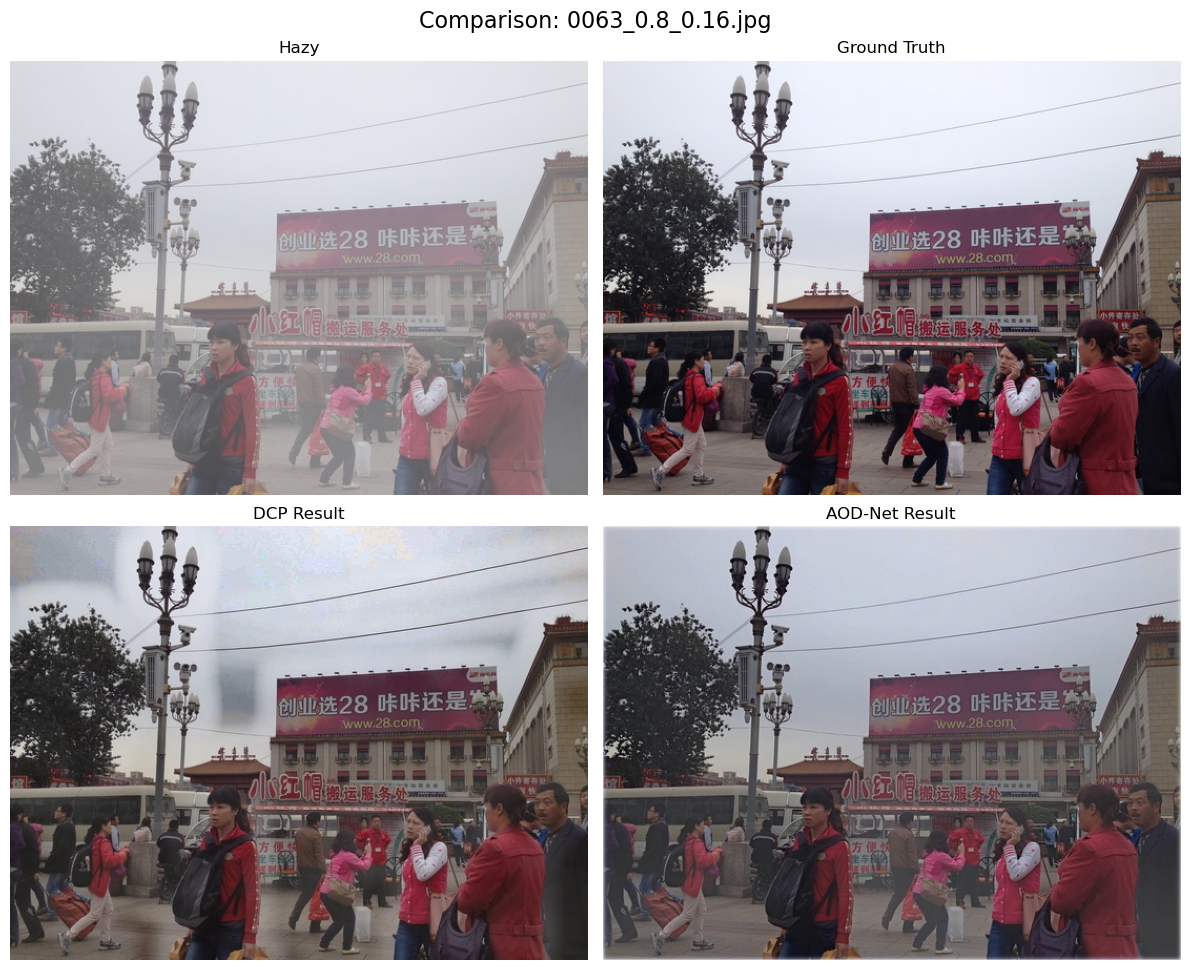

In [33]:
import matplotlib.pyplot as plt
import cv2
import random
from pathlib import Path

# 你需要修改这里的路径，确保结构如下：  
SOTS_OUT_HAZY_DIR = Path("../data/RESIDE/SOTS/outdoor/hazy")
SOTS_OUT_GT_DIR   = Path("../data/RESIDE/SOTS/outdoor/gt")
RESULT_DCP_OUT    = Path("../results/dcp/outdoor")
RESULT_AOD_OUT    = Path("../results/aod/outdoor")

def visualize_4grid(
    hazy_dir, gt_dir, dcp_dir, aod_dir,
    filename=None, figsize=(12, 10)
):
    """
    四图拼图：Hazy / GT / DCP / AOD
    hazy_dir: Path - hazy 图所在目录
    gt_dir: Path - GT 图所在目录
    dcp_dir: Path - DCP 输出图所在目录
    aod_dir: Path - AOD-Net 输出图所在目录
    filename: 指定某个文件（不含路径）；如果 None 则随机选择
    """

    hazy_dir = Path(hazy_dir)
    gt_dir   = Path(gt_dir)
    dcp_dir  = Path(dcp_dir)
    aod_dir  = Path(aod_dir)

    # 自动匹配文件
    hazy_files = sorted([f for f in hazy_dir.iterdir() if f.suffix.lower() in [".png", ".jpg", ".jpeg"]])

    if filename is None:
        hazy_path = random.choice(hazy_files)
    else:
        hazy_path = hazy_dir / filename

    base = hazy_path.stem.split("_")[0]   # 如 "0001_0.8_0.2" → "0001"
    gt_path  = gt_dir / f"{base}.png"
    dcp_path = dcp_dir / f"{hazy_path.name}"
    aod_path = aod_dir / f"{hazy_path.name}"

    # 加载图像（RGB）
    hazy = cv2.cvtColor(cv2.imread(str(hazy_path)), cv2.COLOR_BGR2RGB)
    gt   = cv2.cvtColor(cv2.imread(str(gt_path)),   cv2.COLOR_BGR2RGB)
    dcp  = cv2.cvtColor(cv2.imread(str(dcp_path)),  cv2.COLOR_BGR2RGB)
    aod  = cv2.cvtColor(cv2.imread(str(aod_path)),  cv2.COLOR_BGR2RGB)

    # 绘图
    plt.figure(figsize=figsize)

    plt.subplot(2, 2, 1)
    plt.imshow(hazy)
    plt.title("Hazy")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(gt)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(dcp)
    plt.title("DCP Result")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(aod)
    plt.title("AOD-Net Result")
    plt.axis("off")

    plt.suptitle(f"Comparison: {hazy_path.name}", fontsize=16)
    plt.tight_layout()
    plt.show()


# -------- 示例：SOTS Outdoor 对应拼图 --------
visualize_4grid(SOTS_OUT_HAZY_DIR, SOTS_OUT_GT_DIR, RESULT_DCP_OUT, RESULT_AOD_OUT)

